In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor 
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)  # New metrics
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")



df_spot_led = pd.read_csv("outputs/model1_spot_led_microstructure.csv")
df_fut_led = pd.read_csv("outputs/model2_fut_led_microstructure.csv")

full_spot_ticks = pd.read_csv("TRB_USDT/Archive/trb_usdt_spot_export.csv")
full_spot_ticks["time"] = pd.to_datetime(full_spot_ticks["time"])
full_spot_ticks["mid_price"] = (
    full_spot_ticks["bid_price"] + full_spot_ticks["ask_price"]
) / 2
full_spot_ticks.sort_values("time", inplace=True)

full_futures_ticks = pd.read_csv("TRB_USDT/Archive/trb_usdt_futures_export.csv")
full_futures_ticks["time"] = pd.to_datetime(full_futures_ticks["time"])
full_futures_ticks["mid_price"] = (full_futures_ticks["bid_price"] + full_futures_ticks["ask_price"]) / 2
full_futures_ticks.sort_values("time", inplace=True)

print(f"Spot-Led Events: {len(df_spot_led)}")
print(f"Futures-Led Events: {len(df_fut_led)}")


--- Loading Correct Feature Datasets ---
Futures tick data loaded successfully.
Data loaded successfully.
Spot-Led Events: 15006
Futures-Led Events: 21457


### 2. REGRESSION ANALYSIS FOR SPOT-LED MODEL (Spot -> Futures)


In [100]:
features = [
    "time_since_prev_shock",
    "abs_shock_size",
    "past_trade_vol_10ms",
    "spread",
    "shock_dir",  # Direction of initial shock (+1 or -1)
]
X_spot = df_spot_led[features]
# Use the percentage column as the target
y_spot = df_spot_led["target_fut_percentage"]

# --- ML Model Training ---
# Note: stratify is removed as it's for classification targets
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_spot, y_spot, test_size=0.2, random_state=42, shuffle=False
)

In [101]:
scaler_s = StandardScaler()
X_train_s_scaled = scaler_s.fit_transform(X_train_s)
X_test_s_scaled = scaler_s.transform(X_test_s)

print("\n--- OLS (Linear Regression) Results for SPOT-LED Model ---")
ols_spot = LinearRegression()
ols_spot.fit(X_train_s_scaled, y_train_s)  # Use the SCALED data for OLS
preds_spot_ols = ols_spot.predict(X_test_s_scaled)
mae_ols_s = mean_absolute_error(y_test_s, preds_spot_ols)
r2_ols_s = r2_score(y_test_s, preds_spot_ols)
print(f"OLS MAE: {mae_ols_s:.6f}")
print(f"OLS R-squared (R²): {r2_ols_s:.4f}")


--- OLS (Linear Regression) Results for SPOT-LED Model ---
OLS MAE: 0.001002
OLS R-squared (R²): 0.1571


In [102]:
xgb_spot = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_spot.fit(X_train_s, y_train_s)
preds_spot = xgb_spot.predict(X_test_s)

print("\n--- XGBoost Regressor Results for SPOT-LED Model ---")
mae_s = mean_absolute_error(y_test_s, preds_spot)
r2_s = r2_score(y_test_s, preds_spot)
print(f"Mean Absolute Error (MAE): {mae_s:.6f}")
print(f"R-squared (R²): {r2_s:.4f}")


--- XGBoost Regressor Results for SPOT-LED Model ---
Mean Absolute Error (MAE): 0.001112
R-squared (R²): 0.0123



Feature Importance Scores:
shock_dir                0.818853
past_trade_vol_10ms      0.059743
abs_shock_size           0.047427
spread                   0.042503
time_since_prev_shock    0.031473
dtype: float32


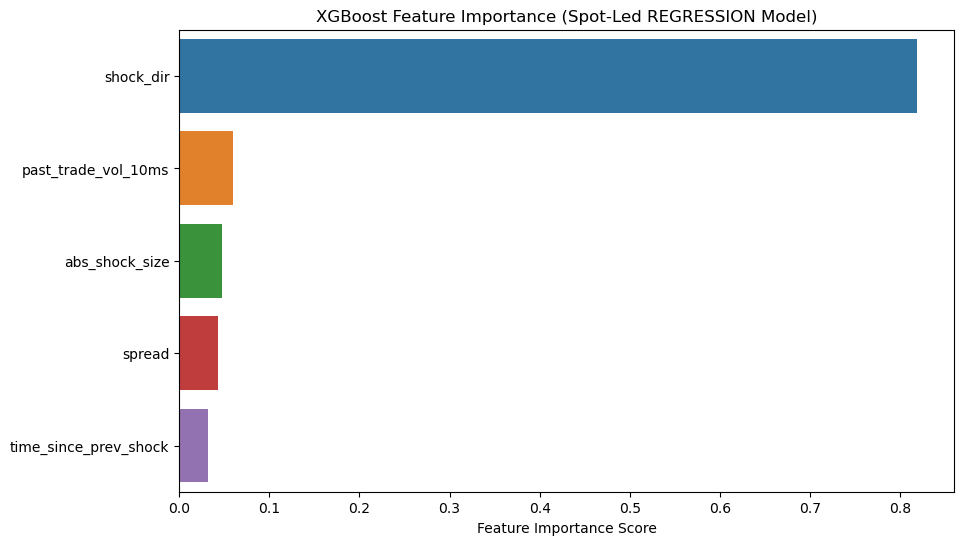

In [103]:
feature_importances_spot = pd.Series(
    xgb_spot.feature_importances_, index=X_train_s.columns
).sort_values(ascending=False)
print("\nFeature Importance Scores:")
print(feature_importances_spot)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_spot, y=feature_importances_spot.index)
plt.title("XGBoost Feature Importance (Spot-Led REGRESSION Model)")
plt.xlabel("Feature Importance Score")
plt.show()

### 3. REGRESSION ANALYSIS FOR FUTURES-LED MODEL (Futures -> Spot)

In [104]:
X_fut = df_fut_led[features]
y_fut = df_fut_led["target_spot_percentage"]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fut, y_fut, test_size=0.2, random_state=42, shuffle=False
)

In [ ]:
scaler_f = StandardScaler()
X_train_f_scaled = scaler_f.fit_transform(X_train_f)
X_test_f_scaled = scaler_f.transform(X_test_f)

ols_fut = LinearRegression()
ols_fut.fit(X_train_f_scaled, y_train_f) 
preds_fut_ols = ols_fut.predict(X_test_f_scaled)
mae_ols_f = mean_absolute_error(y_test_f, preds_fut_ols)
r2_ols_f = r2_score(y_test_f, preds_fut_ols)
print(f"OLS MAE: {mae_ols_f:.6f}")
print(f"OLS R-squared (R²): {r2_ols_f:.4f}")

OLS MAE: 0.000856
OLS R-squared (R²): 0.2071


In [106]:
xgb_fut = XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
xgb_fut.fit(X_train_f, y_train_f)
preds_fut = xgb_fut.predict(X_test_f)

mae_f = mean_absolute_error(y_test_f, preds_fut)
r2_f = r2_score(y_test_f, preds_fut)
print(f"Mean Absolute Error (MAE): {mae_f:.6f}")
print(f"R-squared (R²): {r2_f:.4f}")

Mean Absolute Error (MAE): 0.000771
R-squared (R²): 0.3501


### Feature Importance for Futures-Led Model 


Feature Importance Scores:
shock_dir                0.938335
spread                   0.038674
past_trade_vol_10ms      0.009290
abs_shock_size           0.006935
time_since_prev_shock    0.006766
dtype: float32


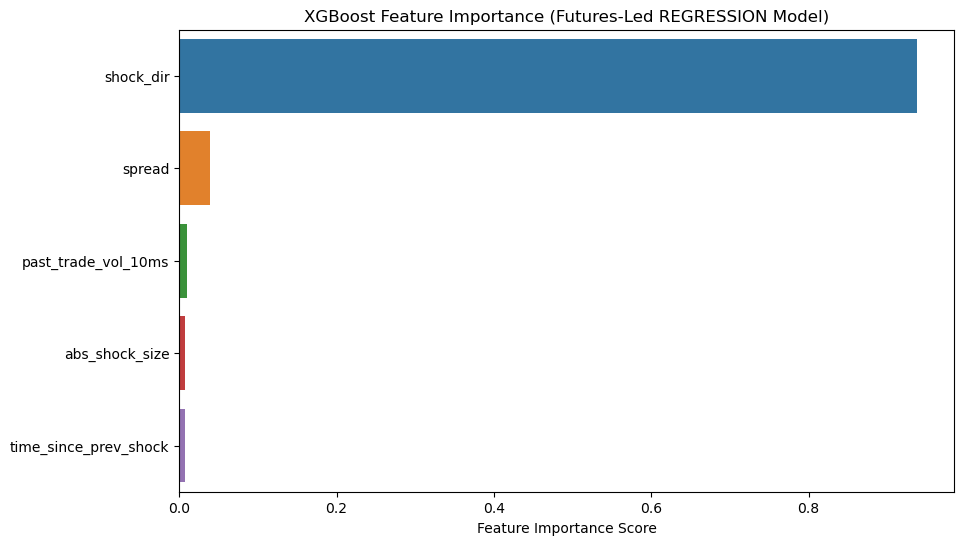

In [107]:
feature_importances_fut = pd.Series(
    xgb_fut.feature_importances_, index=X_train_f.columns
).sort_values(ascending=False)
print("\nFeature Importance Scores:")
print(feature_importances_fut)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_fut, y=feature_importances_fut.index)
plt.title("XGBoost Feature Importance (Futures-Led REGRESSION Model)")
plt.xlabel("Feature Importance Score")
plt.show()

In [ ]:
def analyze_momentum(
    signal_events,
    full_price_ticks,
    horizons_ns=None,
    price_col="mid_price",
    time_col="time",
    shock_dir_col="shock_dir",
    percent=True,  # <-- new flag
    plot=True,
    title="",
):
    # defaults for horizons
    if horizons_ns is None:
        horizons_ns = {
            "3ms": 3 * 1e6,  # 3 minutes in nanoseconds
            "100ms": 100 * 1e6,
            "500ms": 500 * 1e6,
            "1s": 1e9,
            "2s": 2e9,
            "3s": 3e9,
            "4s": 4e9,
            "5s": 5e9,
            "6s": 6e9,
            "7s": 7e9,
            "8s": 8e9,
            "30s": 30e9,
        }

    signal_events = signal_events.copy()
    signal_events[time_col] = pd.to_datetime(signal_events[time_col])
    full_price_ticks[time_col] = pd.to_datetime(full_price_ticks[time_col])
    full_price_ticks.sort_values(time_col, inplace=True)

    t_sig = signal_events[time_col].view("int64").to_numpy()
    t_ticks = full_price_ticks[time_col].view("int64").to_numpy()
    px_ticks = full_price_ticks[price_col].to_numpy()

    idx0 = np.searchsorted(t_ticks, t_sig, side="left")
    idx0 = np.clip(idx0, 0, len(px_ticks) - 1)
    px0 = px_ticks[idx0]
    dirs = signal_events[shock_dir_col].to_numpy()

    px_future: dict[str, np.ndarray] = {}
    for label, ns in sorted(horizons_ns.items(), key=lambda x: x[1]):
        idxf = np.searchsorted(t_ticks, t_sig + ns, side="left")
        idxf = np.clip(idxf, 0, len(px_ticks) - 1)
        px_future[label] = px_ticks[idxf]

    out = signal_events.copy()
    for lbl, px_t in px_future.items():
        raw = (px_t - px0) * dirs
        if percent:
            out[f"abs_mom_{lbl}"] = raw / px0
        else:
            out[f"abs_mom_{lbl}"] = raw

    prev_lbl = None
    for lbl, px_t in px_future.items():
        base = px0 if prev_lbl is None else px_future[prev_lbl]
        raw = (px_t - base) * dirs
        if percent:
            out[f"inc_mom_{prev_lbl or '0'}_to_{lbl}"] = raw / base
        else:
            out[f"inc_mom_{prev_lbl or '0'}_to_{lbl}"] = raw
        prev_lbl = lbl

    if plot:
        abs_cols = [c for c in out if c.startswith("abs_mom_")]
        inc_cols = [c for c in out if c.startswith("inc_mom_")]
        avg_abs = out[abs_cols].mean()
        avg_inc = out[inc_cols].mean()

        fig, ax = plt.subplots(figsize=(6, 6))
        avg_abs.plot(kind="bar", ax=ax, alpha=0.6, label="Abs momentum")
        avg_inc.plot(kind="bar", ax=ax, alpha=0.9, label="Inc momentum")
        ax.axhline(0, color="k", linestyle="--", lw=1)
        ax.set_title(title)
        ax.set_ylabel(
            "Price move × shock direction" + (" (%)" if percent else " (ticks)")
        )
        ax.set_xlabel("Horizon")
        ax.legend()
        ax.grid(axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

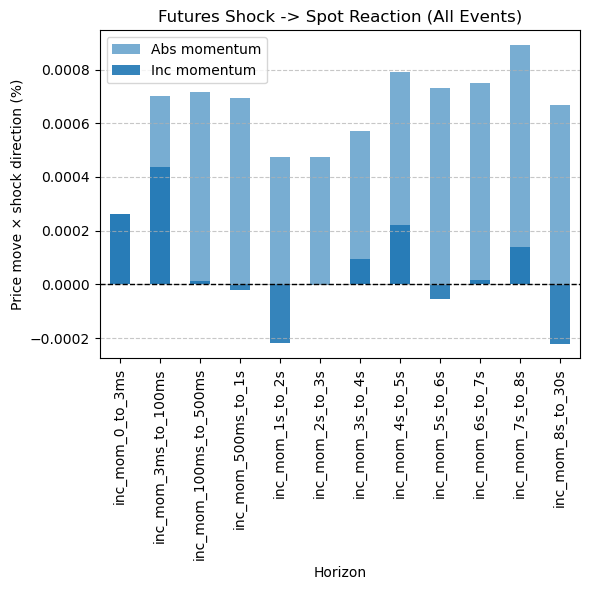

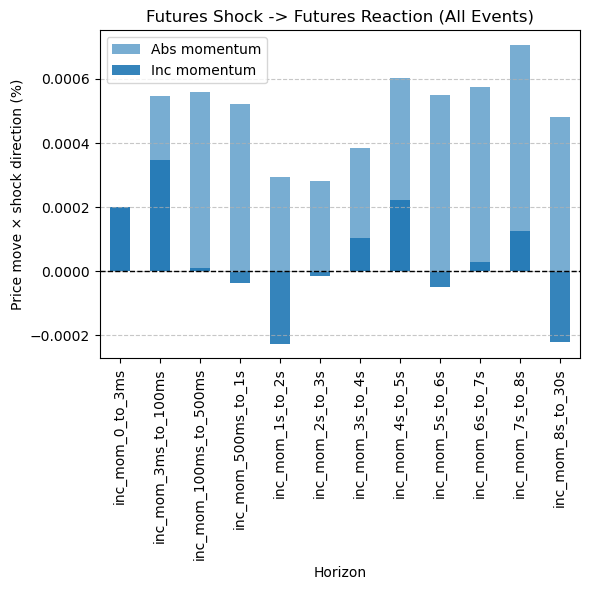

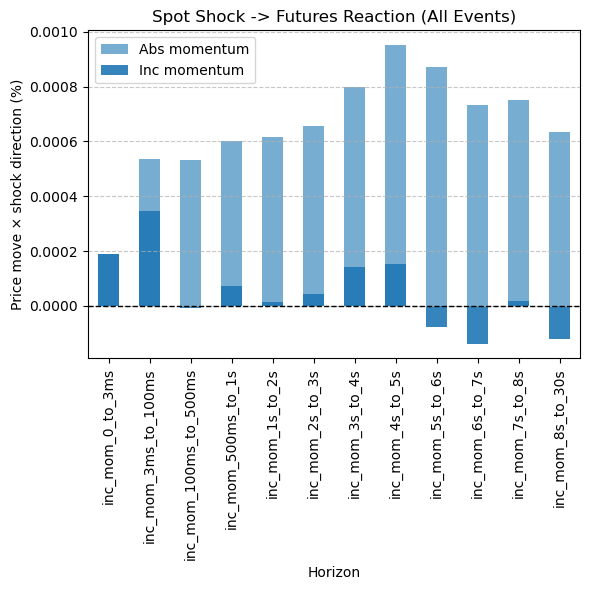

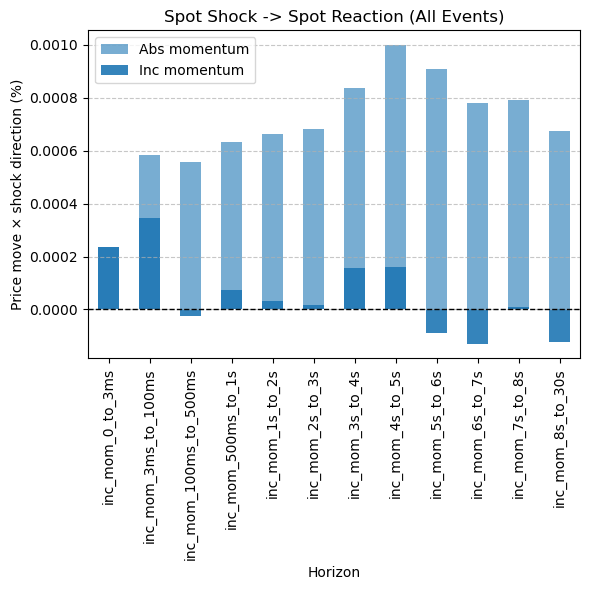

In [109]:
tasks = [
    (df_fut_led, full_spot_ticks, "Futures Shock -> Spot Reaction (All Events)"),
    (df_fut_led, full_futures_ticks, "Futures Shock -> Futures Reaction (All Events)"),
    (df_spot_led, full_futures_ticks, "Spot Shock -> Futures Reaction (All Events)"),
    (df_spot_led, full_spot_ticks, "Spot Shock -> Spot Reaction (All Events)"),
]

for events, price_ticks, title in tasks:
    analyze_momentum(events, price_ticks, title=title)